### Load Packages

In [1]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV, learning_curve

### Load Data

In [2]:
# load data directly from kaggle
os.makedirs("titanic", exist_ok=True)


with zipfile.ZipFile("titanic.zip", "r") as zip_ref:
    zip_ref.extractall("titanic")

print("file has been unzipped to titanic/ folder")

file has been unzipped to titanic/ folder


In [3]:
train_df = pd.read_csv("titanic/train.csv")
test_df = pd.read_csv("titanic/test.csv")
submission_df = pd.read_csv("titanic/gender_submission.csv")

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

In [5]:
# check the data size
print(f"train_df size: {train_df.shape}")

train_df size: (891, 12)


In [6]:
# check if there are any missing values
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There are some missing values in the Age and Cabin columns. 

We can fill the missing values in Age with the median age, and drop the Cabin column since it has too many missing values.
Embarked only have 2 missing we can fill in with mode.

In [7]:
# fill missing values in Age with the median
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())

# fill missing values in Embarked with the most common value
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

# drop Cabin column as it has too many missing values
train_df = train_df.drop(columns=['Cabin'])

In [8]:
# confirm the missing values are filled
train_df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

(1) What was the survival rate?

<Axes: xlabel='Survived'>

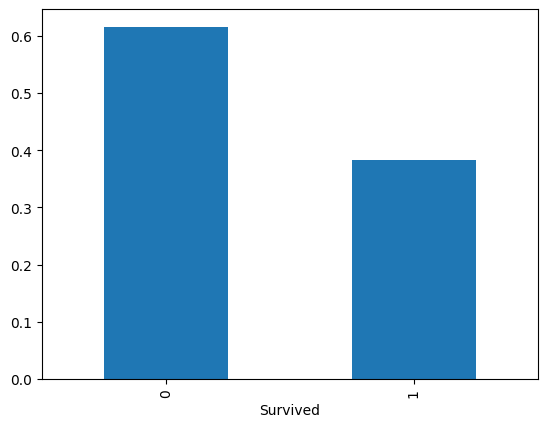

In [9]:
# check the distribution of survival using bar plot
train_df['Survived'].value_counts(normalize=True).plot(kind='bar')


---- Around 40% of people survived.

(2) Due to ladies and children first, is there a difference in survival rate between gender?

In [10]:
# create a crosstab to check the survival rate by gender
pd.crosstab(train_df['Sex'], train_df['Survived'], normalize='index')

Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


--- The survival rate for female was significantly higher than the survival rate for male.

(3) Is there a difference in survival rate between ticket class?

In [11]:
# create a crosstab to check the survival rate by Pclass
pd.crosstab(train_df['Pclass'], train_df['Survived'], normalize='index')

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


<Axes: xlabel='Pclass', ylabel='Survived'>

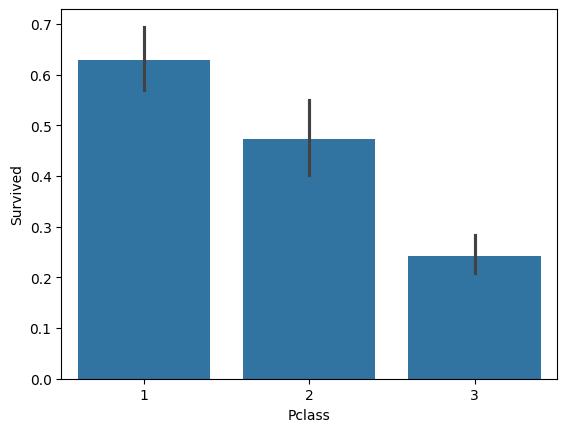

In [12]:
# visualize the survival rate by Pclass
sns.barplot(x='Pclass', y='Survived', data=train_df)

--- Higher ticker class had higher survival rate in general.

(4) Is there difference between age and survival rate? (higher survival rate for children?)

<Axes: xlabel='Survived', ylabel='Age'>

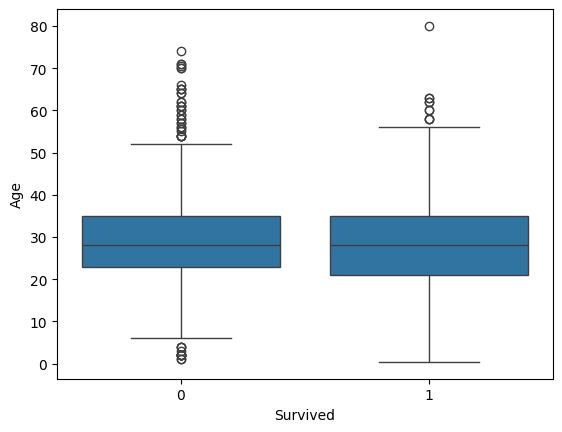

In [13]:
# create boxplot to check the distribution of age by survival
sns.boxplot(x='Survived', y='Age', data=train_df)

--- There wasn't showing higher survival rate for children by general checking. There wasn't a clear pattern between age and survival rate.

(5) Is there a higher survival rate for those whose aboard alone or with family?

<Axes: xlabel='FamilySize', ylabel='Survived'>

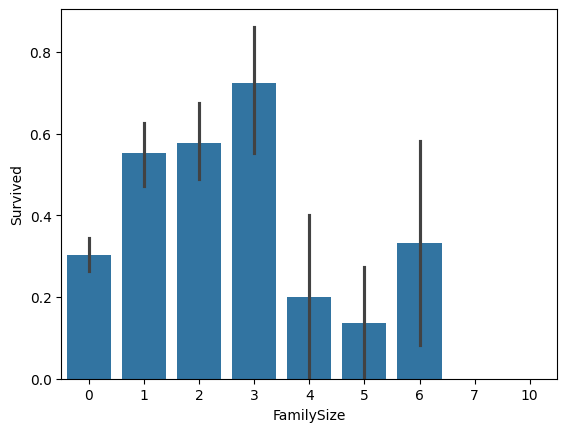

In [14]:
# combine the SibSp (number of siblings/spouses) and Parch (number of parents/children) columns to create a new feature FamilySize
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch']
sns.barplot(x='FamilySize', y='Survived', data=train_df)

--- People who have 1-3 family members aboard together tend to have higher survival rate. Those who aboard alone or with more then 3 family members had lower survival rate. 

(6) Is survival rate related with port of embarkation?

In [15]:
pd.crosstab(train_df['Embarked'], train_df['Survived'], normalize='index')

Survived,0,1
Embarked,,
C,0.446429,0.553571
Q,0.610390,0.389610
S,0.660991,0.339009


--- Seems like people who aboard from Cherbourg had higher survival rate compared to those who aboard from the other two (Queenstown and Southampton)

<Axes: xlabel='Embarked'>

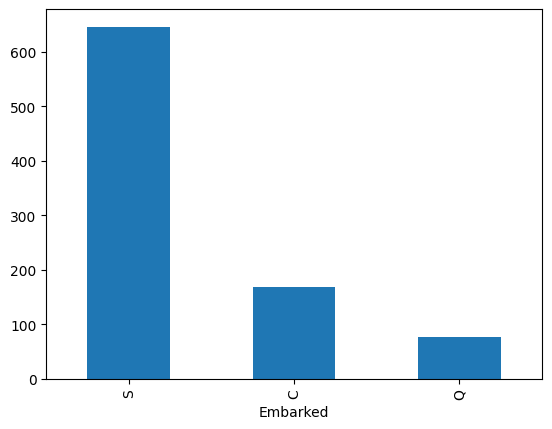

In [16]:
# check the distribution of Embarked
train_df['Embarked'].value_counts().plot(kind='bar')

--- But most people aboard from Southampton, so it might not be a fair comparison.

(7) Is survival rate related with ticket fare?

<Axes: xlabel='Survived', ylabel='Fare'>

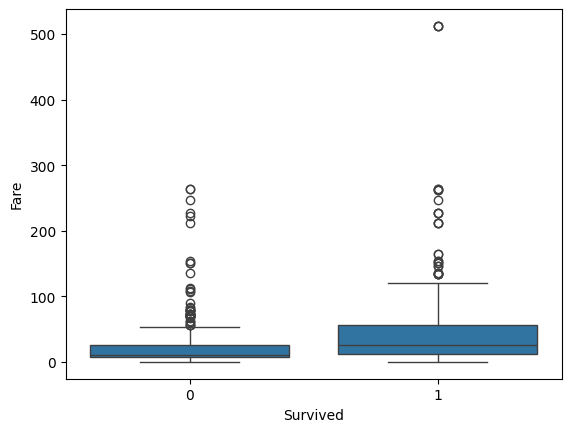

In [17]:
sns.boxplot(x='Survived', y='Fare', data=train_df)

--- Looks like passengers who survived in general paid higher fare. But it is not a strong correlation. There were also a lot people who paid high fare also did not survive and people who paid low fare also survived.

In [18]:
# Get title from Name column for feature engineering
train_df['Title'] = train_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
train_df['Title'].value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64

### Feature Engineering

In [19]:
# add column Survive for test
test_df['Survived'] = None

# Let's combine train and test data for feature engineering
combined = pd.concat([train_df, test_df], ignore_index=True)
combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Title,Cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1.0,Mr,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1.0,Mrs,NaN
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0.0,Miss,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1.0,Mrs,NaN
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0.0,Mr,NaN


Get Title

In [20]:
# Get title from Name column for feature engineering
combined["Title"] = combined["Name"].str.extract(r' ([A-Za-z]+)\.', expand=False)

combined["Title"] = combined["Title"].replace(
    ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
combined["Title"] = combined["Title"].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

combined['Title'].value_counts()

Title
Mr        757
Miss      264
Mrs       198
Master     61
Rare       29
Name: count, dtype: int64

Get FamilySize

In [21]:
combined["FamilySize"] = combined["SibSp"] + combined["Parch"]

Encode Sex, Title, and Embarked

In [22]:
# encode sex
combined["Sex"] = combined["Sex"].map({"male": 0, "female": 1})

In [23]:
# encode Title
combined["Title"] = combined["Title"].map({
    'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4
})

In [24]:
# encode Embarked
combined["Embarked"] = combined["Embarked"].map({'S': 0, 'C': 1, 'Q': 2})

Missing values

In [25]:
# fill missing values in Age with the median
combined['Age'] = combined['Age'].fillna(combined['Age'].median())

# fill missing values in Embarked with the most common value
combined['Embarked'] = combined['Embarked'].fillna(combined['Embarked'].mode()[0])

# drop Cabin column as it has too many missing values
combined = combined.drop(columns=['Cabin'])

# fill fare with the median
combined['Fare'] = combined['Fare'].fillna(combined['Fare'].median())

### Split train and test

All train and test processed, split them back for modeling.

In [26]:
train_processed = combined[combined["Survived"].notnull()]
test_processed = combined[combined["Survived"].isnull()]

In [27]:
train_processed.shape # confirm it is the same row count as original train_df

(891, 13)

In [28]:
# confirm no missing values for train_processed
train_processed.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
FamilySize     0
Title          0
dtype: int64

In [29]:
train_processed.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,1,1,2
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,0,1,2
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0,0,0


In [30]:
features = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title"]
X_train = train_processed[features]
y_train = train_processed["Survived"].astype(int)
X_test = test_processed[features]

### Modeling

Try random forest model with 100 trees

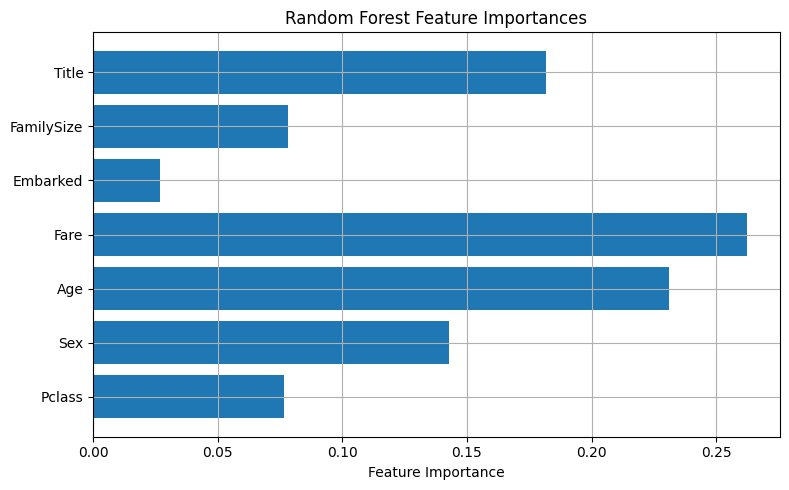

In [31]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

# get importance of features
importances = model.feature_importances_
features = X_train.columns

# visualize feature importances
plt.figure(figsize=(8, 5))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
# get the cross-validation score
cv_score = cross_val_score(model, X_train, y_train, cv=5)
print("cross validation score：", cv_score.mean())

cross validation score： 0.8148138848785387


--- The model results seems to be good enough

### Get Submission File (initial)

In [33]:
# submission = pd.DataFrame({
#     "PassengerId": test_processed["PassengerId"].astype(int),
#     "Survived": predictions.astype(int)
# })
# submission.to_csv("titanic_submission.csv", index=False)

### Optimal

Try more models

Including Logistic Regression, KNN, SVM, Gradient Boosting, and put Random Forest back for comparison.

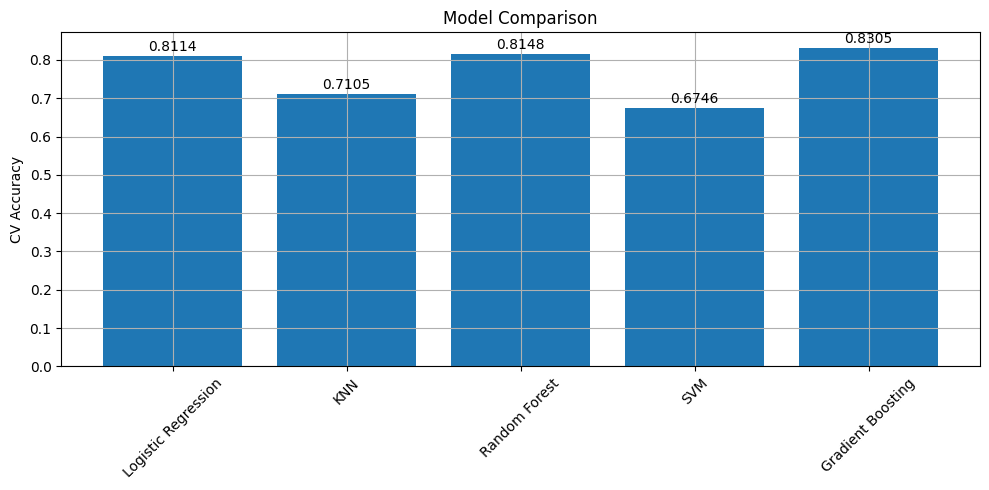

In [34]:
# Put models together
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {} # create a dictionary to store the results

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    results[name] = scores.mean() # store the mean accuracy for each model

plt.figure(figsize=(10,5))
bars = plt.bar(results.keys(), results.values())

# plot the accuracy values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        yval + 0.005,
        f"{yval:.4f}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.ylabel("CV Accuracy")
plt.title("Model Comparison")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

--- Gradient Boosting have the highest accuracy.

Focus on Gradient Boosting and do some GridSearch for optimization

In [35]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# set up the parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# use GridSearchCV to find the best parameters for Gradient Boosting
grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("best parameter:", grid.best_params_)
print("best CV score:", grid.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
best parameter: {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
best CV score: 0.8428974954491244


check for the warning

In [36]:
print(X_train.isnull().sum())

Pclass        0
Sex           0
Age           0
Fare          0
Embarked      0
FamilySize    0
Title         0
dtype: int64


In [37]:
print(X_train.dtypes)

Pclass          int64
Sex             int64
Age           float64
Fare          float64
Embarked        int64
FamilySize      int64
Title           int64
dtype: object


In [38]:
print(X_train.nunique())


Pclass          3
Sex             2
Age            88
Fare          248
Embarked        3
FamilySize      9
Title           5
dtype: int64


"invalid value encountered in cast" -- all look good, ignore and hide.

Understand this model

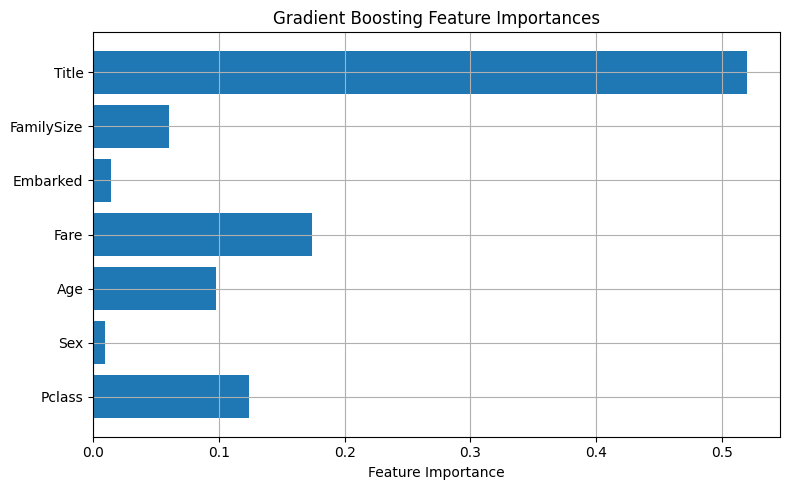

In [39]:
# plot the feature importances
best_model = grid.best_estimator_

importances = best_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(8, 5))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Gradient Boosting Feature Importances")
plt.tight_layout()
plt.grid(True)
plt.show()

--- `Title` is the most important feature here, probably because it reflects both gender, age, and marriage.


--- Compare with RF, GBDT is a little harder to explain, a lot features are not important, but accuracy is higher.

Plot the learning curve for the best model to check for overfitting

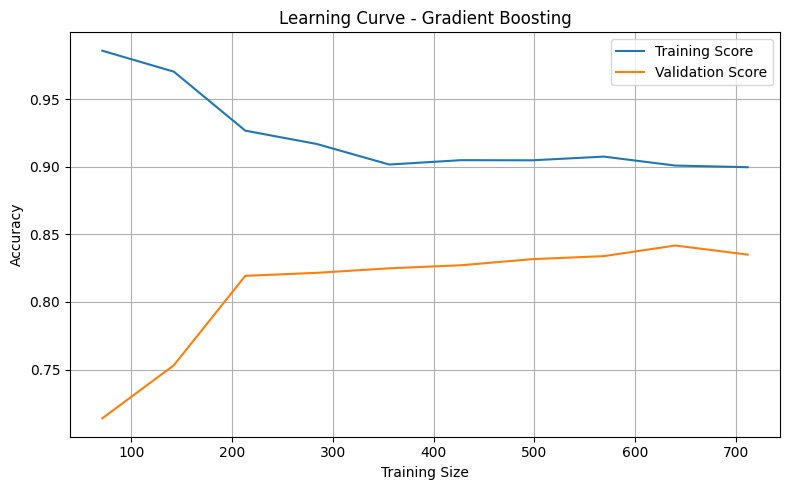

In [40]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, val_mean, label='Validation Score')
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Gradient Boosting")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

--- There is no big gap between training and validation scores, indicating no overfitting.

--- Both scores are pretty high, indicating the model is performing well on both training and validation sets.

### Get Submission File (final)

In [ ]:
# final_model = grid.best_estimator_
# final_model.fit(X_train, y_train)

# predictions = final_model.predict(X_test)

# submission = pd.DataFrame({
#     "PassengerId": test_processed["PassengerId"].astype(int),
#     "Survived": predictions.astype(int)
# })
# submission.to_csv("gbdt_submission.csv", index=False)